In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

In [11]:
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [15]:
f = 0.5                  # Frequenz in Hz
omega = 2 * np.pi * f    # Kreisfrequenz in rad/s

print(omega)            
print(omega == np.pi)

3.141592653589793
True


(34,)
(34,)
(34,)


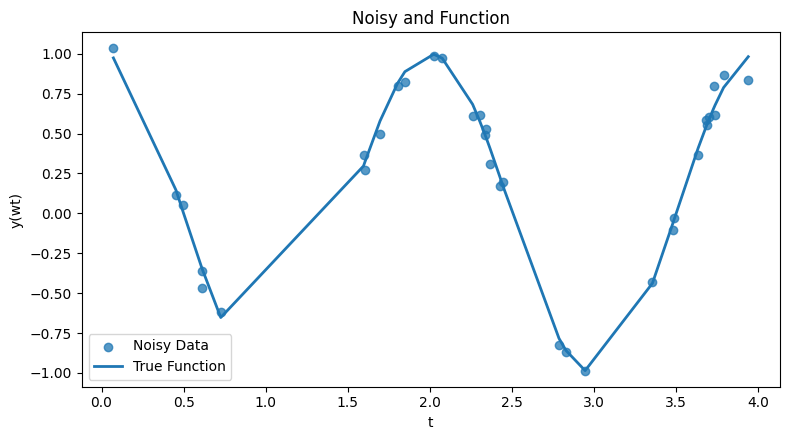

In [47]:
# N reellen Zufallswerten aus einer gleichverteilten Verteilung auf dem Intervall [0,4]
N = np.random.randint(15, 41)         # 15 ≤ N ≤ 40
t_np = np.random.uniform(0.0, 4.0, N) # N Punkte in [0, 4]
t_np = np.sort(t_np)                     # optional: sortieren

y_true_np = np.cos(omega * t_np)
sigma = np.random.uniform(0.05, 0.15)
noise = np.random.normal(loc=0.0, scale=sigma, size=y_true_np.shape)
y_noisy_np = y_true_np + noise

print(t_np.shape)
print(y_true_np.shape)
print(y_noisy_np.shape) 

plt.figure(figsize=(8,4.5))
plt.scatter(t_np, y_noisy_np, label="Noisy Data", alpha=0.75)
plt.plot(t_np, y_true_np, label= "True Function", linewidth=2)
plt.legend()
plt.title("Noisy and Function")
plt.xlabel("t")
plt.ylabel("y(wt)")
plt.tight_layout()
plt.show()

### Torch Data

In [33]:
t_data = torch.from_numpy(t_np).float().reshape(-1,1).to(device)
y_noisy = torch.from_numpy(y_noisy_np).float().reshape(-1,1).to(device)

print(t_data.shape)
print(y_noisy.shape) # Spalten Vektor

torch.Size([18, 1])
torch.Size([18, 1])


# Model

In [34]:
class PModel(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.l1 = nn.Linear(1, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.l3 = nn.Linear(hidden, 1)
        self.act = nn.Tanh()
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.l1.weight); nn.init.zeros_(self.l1.bias)
        nn.init.xavier_uniform_(self.l2.weight); nn.init.zeros_(self.l2.bias)
        nn.init.xavier_uniform_(self.l3.weight); nn.init.zeros_(self.l3.bias)
        
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x
    
model = PModel().to(device)
print("Param-Anzahl:", sum(p.numel() for p in model.parameters()))

Param-Anzahl: 1153


### Loss definieren

In [38]:
mse = nn.MSELoss()

def pinn_losses(model, t_data, y_noisy, t_phys, ic_value0=1, ic_value1=0):
    # 1) Data Loss
    pred_data = model(t_data)
    data_loss = mse(pred_data, y_noisy)
    
    # 2) Physics Loss
    t_phys_req = t_phys.clone().detach().to(device).requires_grad_(True) # Clonen wegen gradient
    pred_phys = model(t_phys_req)
    
    dy_dt_1 = torch.autograd.grad(
        outputs=pred_phys,
        inputs=t_phys_req,
        grad_outputs=torch.ones_like(pred_phys),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    dy_dt_2 = torch.autograd.grad(
        outputs=dy_dt_1,
        inputs=t_phys_req,
        grad_outputs=torch.ones_like(dy_dt_1),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    f_loss = 0.5 
    omega_loss = 2 * np.pi * f_loss
    
    residual = dy_dt_2 + omega_loss**2*pred_phys
    physics_loss = mse(residual, torch.zeros_like(residual))
    
    # 3) IC-Loss
    t0 = torch.zeros(1, 1, device=device)
    y0_hat = model(t0)
    ic_loss_1 = mse(y0_hat, torch.tensor([[ic_value0]], dtype=torch.float32, device=device))
    
    t1 = torch.ones(1, 1, device=device)
    y1_hat = model(t1)
    ic_loss_2 = mse(y1_hat, torch.tensor([[ic_value1]], dtype=torch.float32, device=device))
    
    ic_loss = ic_loss_1 + ic_loss_2
    
    loss = data_loss + physics_loss + ic_loss
    
    return loss, data_loss.detach(), physics_loss.detach(), ic_loss.detach() 

### Training

In [44]:
epochs = 10000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

t_phys = torch.linspace(0.0, 4.0, steps=200).reshape(-1, 1).to(device)

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    loss, dL, pL, icL = pinn_losses(model, t_data, y_noisy, t_phys)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"epoch {epoch:4d} | total {loss.item():.6f} | data {dL.item():.6f} | phys {pL.item():.6f} | ic {icL.item():.6f}")
 
    

epoch 1000 | total 0.596065 | data 0.118379 | phys 0.033877 | ic 0.443809
epoch 2000 | total 0.595822 | data 0.118023 | phys 0.033766 | ic 0.444033
epoch 3000 | total 0.595687 | data 0.117838 | phys 0.033642 | ic 0.444207
epoch 4000 | total 0.595610 | data 0.117751 | phys 0.033503 | ic 0.444356
epoch 5000 | total 0.595537 | data 0.117667 | phys 0.033560 | ic 0.444309
epoch 6000 | total 0.595501 | data 0.117614 | phys 0.033577 | ic 0.444309
epoch 7000 | total 0.595527 | data 0.117582 | phys 0.033103 | ic 0.444842
epoch 8000 | total 0.595493 | data 0.117596 | phys 0.033621 | ic 0.444276
epoch 9000 | total 0.595497 | data 0.117599 | phys 0.033621 | ic 0.444277
epoch 10000 | total 0.595553 | data 0.117868 | phys 0.035194 | ic 0.442490


### Vorhersage

In [45]:
# Vorhersagekurven für Plot
t_dense = np.linspace(0.0, 2.0, 400).reshape(-1,1).astype(np.float32)
y_exact_dense = np.cos(omega * t_dense)


with torch.no_grad():
    y_pred_dense = model(torch.from_numpy(t_dense).to(device)).cpu().numpy()[:,0]

<Figure size 800x450 with 0 Axes>

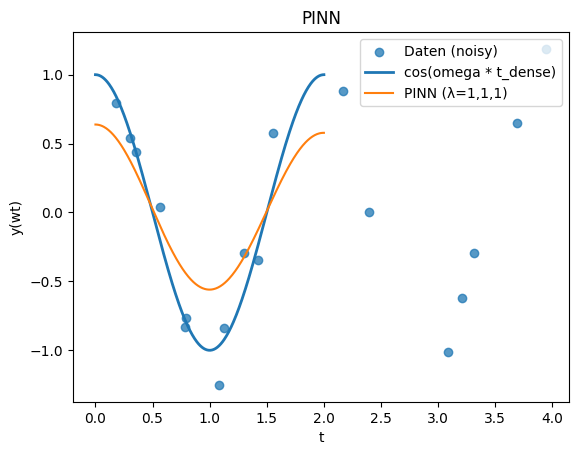

In [46]:
plt.figure(figsize=(8,4.5))
plt.figure()
plt.scatter(t_np, y_noisy_np, label="Daten (noisy)", alpha=0.75)
plt.plot(t_dense[:,0], y_exact_dense, label="cos(omega * t_dense)", linewidth=2)
plt.plot(t_dense[:,0], y_pred_dense, label="PINN (λ=1,1,1)")
plt.xlabel("t"); plt.ylabel("y(wt)"); plt.legend(); plt.title("PINN")
plt.show()

# Korrektur

omega = 3.141592653589793


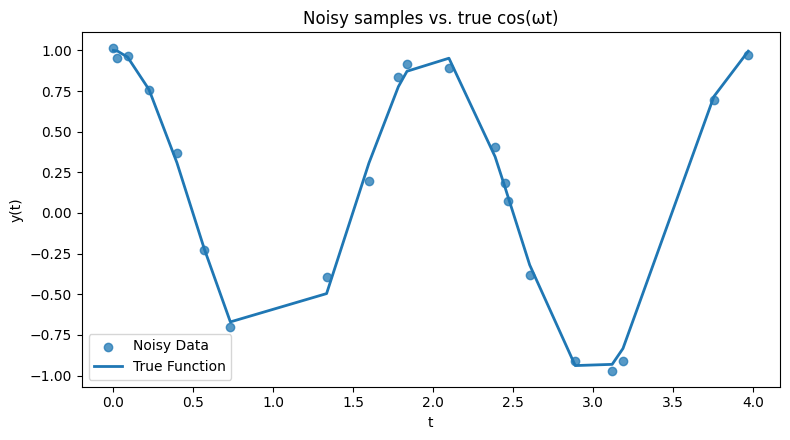

Param-Anzahl: 1153
epoch  200 | total 8.962310 | data 0.484680 | phys 0.201727 | ic 0.746899
epoch  400 | total 8.816050 | data 0.482351 | phys 0.214081 | ic 0.726329
epoch  600 | total 7.838766 | data 0.465500 | phys 0.229110 | ic 0.622771
epoch  800 | total 7.061927 | data 0.440692 | phys 0.331614 | ic 0.496316
epoch 1000 | total 6.827065 | data 0.435299 | phys 0.354814 | ic 0.461770
epoch 1200 | total 6.646955 | data 0.429539 | phys 0.390681 | ic 0.426401
epoch 1400 | total 6.458961 | data 0.425767 | phys 0.403837 | ic 0.401401
epoch 1600 | total 6.097687 | data 0.414034 | phys 0.434566 | ic 0.351082
epoch 1800 | total 6.026618 | data 0.408880 | phys 0.446160 | ic 0.338694
epoch 2000 | total 5.882886 | data 0.402258 | phys 0.441593 | ic 0.327267
epoch 2200 | total 5.691388 | data 0.392326 | phys 0.434409 | ic 0.312702
epoch 2400 | total 5.508829 | data 0.378149 | phys 0.439367 | ic 0.293384
epoch 2600 | total 5.189623 | data 0.360690 | phys 0.424888 | ic 0.270449
epoch 2800 | total 

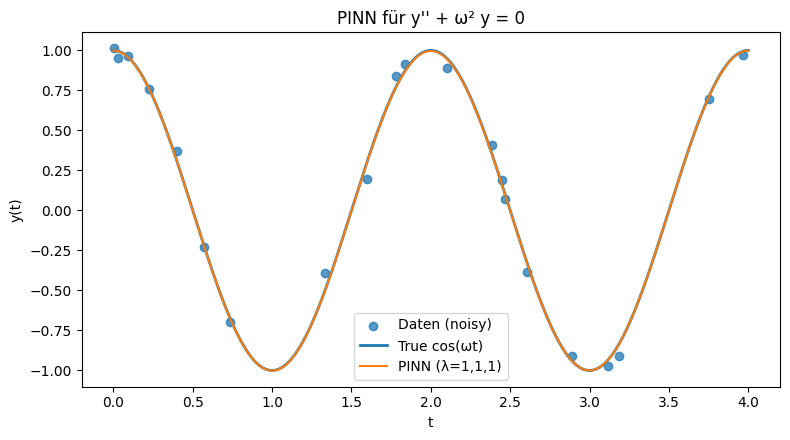

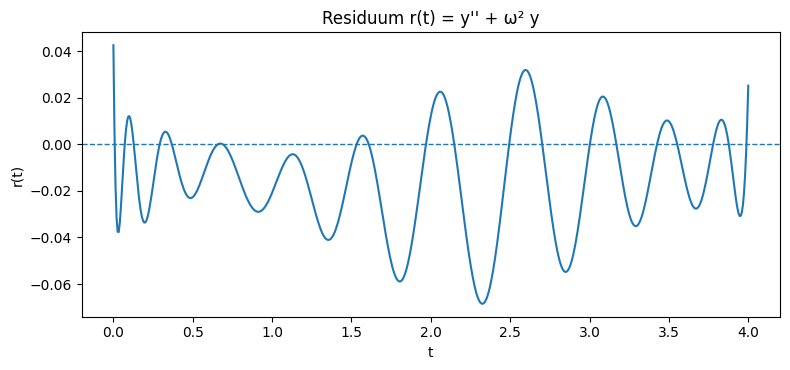

In [52]:
# PINN für y''(t) + ω^2 y(t) = 0 mit IC: y(0)=1, y'(0)=0
# - Generiert verrauschte Messdaten um cos(ω t)
# - Trainiert ein PINN (Data + Physics + IC)
# - Plottet Vorhersage vs. True und Residuum r(t)=y''+ω^2 y

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Setup --------------------
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Physik-Parameter
f = 0.5                       # Frequenz [Hz]
omega = 2 * np.pi * f         # Kreisfrequenz [rad/s] = π
print("omega =", omega)

# -------------------- Daten erzeugen --------------------
# N zufällige Messpunkte t in [0,4]
N = np.random.randint(15, 41)               # 15 ≤ N ≤ 40
t_np = np.random.uniform(0.0, 4.0, N)
t_np = np.sort(t_np)                        # sortieren für hübschere Plots

# Ground truth + Rauschen
y_true_np = np.cos(omega * t_np)
sigma = np.random.uniform(0.05, 0.15)       # Rauschpegel
noise = np.random.normal(0.0, sigma, size=y_true_np.shape)
y_noisy_np = y_true_np + noise

# Torch-Tensoren
t_data = torch.from_numpy(t_np.astype(np.float32)).reshape(-1,1).to(device)
y_noisy = torch.from_numpy(y_noisy_np.astype(np.float32)).reshape(-1,1).to(device)

# Visualisierung der Rohdaten
plt.figure(figsize=(8,4.5))
plt.scatter(t_np, y_noisy_np, label="Noisy Data", alpha=0.75)
plt.plot(t_np, y_true_np, label="True Function", linewidth=2)
plt.legend()
plt.title("Noisy samples vs. true cos(ωt)")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.tight_layout()
plt.show()

# -------------------- Modell --------------------
class PModel(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.l1 = nn.Linear(1, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.l3 = nn.Linear(hidden, 1)
        self.act = nn.Tanh()
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.l1.weight); nn.init.zeros_(self.l1.bias)
        nn.init.xavier_uniform_(self.l2.weight); nn.init.zeros_(self.l2.bias)
        nn.init.xavier_uniform_(self.l3.weight); nn.init.zeros_(self.l3.bias)
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

model = PModel().to(device)
mse = nn.MSELoss()
print("Param-Anzahl:", sum(p.numel() for p in model.parameters()))

# Hilfsfunktion: d/dt via Autograd
def grad_wrt_t(y, t):
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]

# -------------------- PINN-Losses --------------------
def pinn_losses(model,
                t_data, y_noisy,
                t_phys, omega,
                ic_value0=1.0, ic_value1=0.0,
                lambda_data=1.0, lambda_phys=1.0, lambda_ic=1.0):
    # 1) Data Loss
    pred_data = model(t_data)
    data_loss = mse(pred_data, y_noisy)

    # 2) Physics Loss (Kollokationspunkte, Ableitungen nach t)
    t_phys_req = t_phys.clone().detach().to(device).requires_grad_(True)
    pred_phys = model(t_phys_req)
    d1 = grad_wrt_t(pred_phys, t_phys_req)        # y'
    d2 = grad_wrt_t(d1, t_phys_req)               # y''
    residual = d2 + (omega**2) * pred_phys        # r = y'' + ω^2 y
    physics_loss = mse(residual, torch.zeros_like(residual))

    # 3) IC-Loss: y(0)=1, y'(0)=0
    t0 = torch.zeros(1,1, device=device, requires_grad=True)
    y0_hat = model(t0)
    dy_dt_0 = grad_wrt_t(y0_hat, t0)              # y'(0)
    ic_loss_pos = mse(y0_hat, torch.tensor([[ic_value0]], dtype=torch.float32, device=device))
    ic_loss_vel = mse(dy_dt_0, torch.tensor([[ic_value1]], dtype=torch.float32, device=device))
    ic_loss = ic_loss_pos + ic_loss_vel

    total = lambda_data*data_loss + lambda_phys*physics_loss + lambda_ic*ic_loss
    # Für Logging detach-en:
    return total, data_loss.detach(), physics_loss.detach(), ic_loss.detach()

# -------------------- Training --------------------
epochs = 20000
lr = 1e-3
lambda_data, lambda_phys, lambda_ic = 1.0, 5.0, 10.0

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Kollokationspunkte im Trainingsintervall (leichtes Jitter pro Epoche)
t_phys_base = torch.linspace(0.0, 4.0, steps=160).reshape(-1,1).to(device)

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    t_phys = (t_phys_base + 0.01*torch.randn_like(t_phys_base)).clamp(0,4)
    total, dL, pL, icL = pinn_losses(
        model, t_data, y_noisy, t_phys, omega,
        ic_value0=1.0, ic_value1=0.0,
        lambda_data=lambda_data, lambda_phys=lambda_phys, lambda_ic=lambda_ic
    )
    total.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"epoch {epoch:4d} | total {total.item():.6f} | data {dL.item():.6f} | phys {pL.item():.6f} | ic {icL.item():.6f}")

# -------------------- Vorhersage-Plot --------------------
t_dense = np.linspace(0.0, 4.0, 600).reshape(-1,1).astype(np.float32)
y_true_dense = np.cos(omega * t_dense)

with torch.no_grad():
    y_pred_dense = model(torch.from_numpy(t_dense).to(device)).cpu().numpy()[:,0]

plt.figure(figsize=(8,4.5))
plt.scatter(t_np, y_noisy_np, label="Daten (noisy)", alpha=0.75)
plt.plot(t_dense[:,0], y_true_dense[:,0], label="True cos(ωt)", linewidth=2)
plt.plot(t_dense[:,0], y_pred_dense, label="PINN (λ=1,1,1)")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend(); plt.title("PINN für y'' + ω² y = 0")
plt.tight_layout(); plt.show()

# -------------------- Residuum-Plot --------------------
# ACHTUNG: hier NICHT no_grad verwenden, sonst keine Ableitungen möglich!
t_res = torch.from_numpy(t_dense).to(device).requires_grad_(True)
y_res = model(t_res)
d1_res = grad_wrt_t(y_res, t_res)
d2_res = grad_wrt_t(d1_res, t_res)
resid_np = (d2_res + (omega**2) * y_res).detach().cpu().numpy()[:,0]

plt.figure(figsize=(8,3.8))
plt.plot(t_dense[:,0], resid_np)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuum r(t) = y'' + ω² y")
plt.xlabel("t"); plt.ylabel("r(t)")
plt.tight_layout(); plt.show()


omega = 3.141592653589793


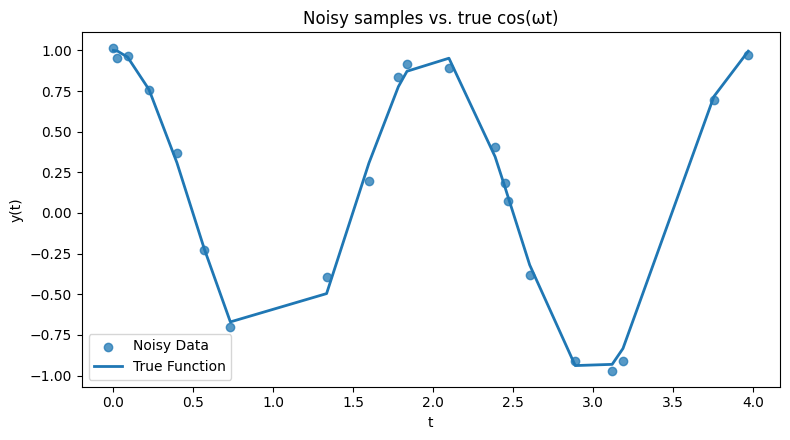

Param-Anzahl: 4353
epoch 1000 | total 6.040007 | data 0.428237 | phys 0.573596 | ic 0.389098
epoch 2000 | total 3.892016 | data 0.329695 | phys 0.656549 | ic 0.159267
epoch 3000 | total 2.859432 | data 0.223693 | phys 0.624183 | ic 0.076319
epoch 4000 | total 2.786844 | data 0.209080 | phys 0.633234 | ic 0.067806
epoch 5000 | total 2.699279 | data 0.199999 | phys 0.618514 | ic 0.064374
epoch 6000 | total 2.582301 | data 0.189577 | phys 0.598319 | ic 0.059777
epoch 7000 | total 2.412249 | data 0.170555 | phys 0.567294 | ic 0.053981
epoch 8000 | total 1.181609 | data 0.072995 | phys 0.294326 | ic 0.022564
epoch 9000 | total 0.395672 | data 0.019159 | phys 0.109694 | ic 0.004743
epoch 10000 | total 0.209097 | data 0.009110 | phys 0.060039 | ic 0.001987
epoch 11000 | total 0.068148 | data 0.004279 | phys 0.019887 | ic 0.000421
epoch 12000 | total 0.027903 | data 0.002901 | phys 0.008194 | ic 0.000042
epoch 13000 | total 0.020607 | data 0.002744 | phys 0.005870 | ic 0.000025
epoch 14000 | t

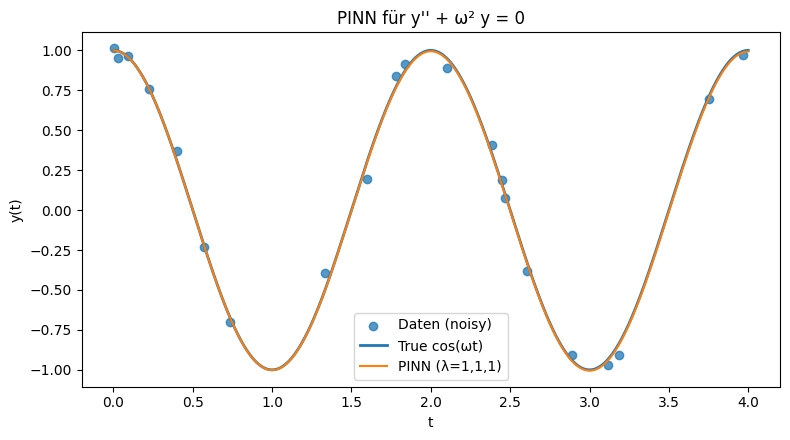

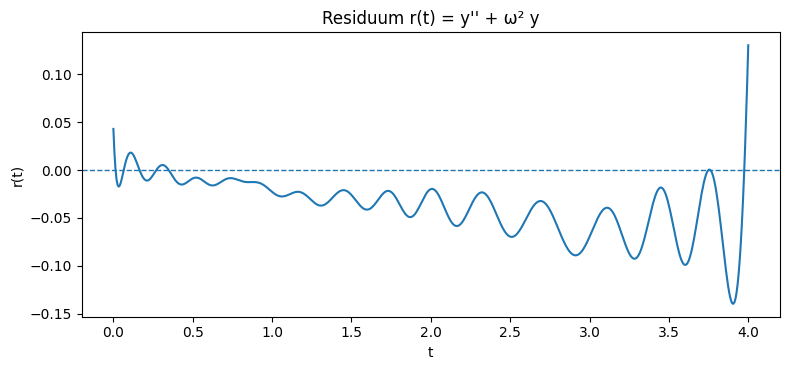

In [56]:
# PINN für y''(t) + ω^2 y(t) = 0 mit IC: y(0)=1, y'(0)=0
# - Generiert verrauschte Messdaten um cos(ω t)
# - Trainiert ein PINN (Data + Physics + IC)
# - Plottet Vorhersage vs. True und Residuum r(t)=y''+ω^2 y

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# -------------------- Setup --------------------
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Physik-Parameter
f = 0.5                       # Frequenz [Hz]
omega = 2 * np.pi * f         # Kreisfrequenz [rad/s] = π
print("omega =", omega)

# -------------------- Daten erzeugen --------------------
# N zufällige Messpunkte t in [0,4]
N = np.random.randint(15, 41)               # 15 ≤ N ≤ 40
t_np = np.random.uniform(0.0, 4.0, N)
t_np = np.sort(t_np)                        # sortieren für hübschere Plots

# Ground truth + Rauschen
y_true_np = np.cos(omega * t_np)
sigma = np.random.uniform(0.05, 0.15)       # Rauschpegel
noise = np.random.normal(0.0, sigma, size=y_true_np.shape)
y_noisy_np = y_true_np + noise

# Torch-Tensoren
t_data = torch.from_numpy(t_np.astype(np.float32)).reshape(-1,1).to(device)
y_noisy = torch.from_numpy(y_noisy_np.astype(np.float32)).reshape(-1,1).to(device)

# Visualisierung der Rohdaten
plt.figure(figsize=(8,4.5))
plt.scatter(t_np, y_noisy_np, label="Noisy Data", alpha=0.75)
plt.plot(t_np, y_true_np, label="True Function", linewidth=2)
plt.legend()
plt.title("Noisy samples vs. true cos(ωt)")
plt.xlabel("t")
plt.ylabel("y(t)")
plt.tight_layout()
plt.show()

# -------------------- Modell --------------------
class PModel(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.l1 = nn.Linear(1, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.l3 = nn.Linear(hidden, 1)
        self.act = nn.Tanh()
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.l1.weight); nn.init.zeros_(self.l1.bias)
        nn.init.xavier_uniform_(self.l2.weight); nn.init.zeros_(self.l2.bias)
        nn.init.xavier_uniform_(self.l3.weight); nn.init.zeros_(self.l3.bias)
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x

model = PModel().to(device)
mse = nn.MSELoss()
print("Param-Anzahl:", sum(p.numel() for p in model.parameters()))

# Hilfsfunktion: d/dt via Autograd
def grad_wrt_t(y, t):
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]

# -------------------- PINN-Losses --------------------
def pinn_losses(model,
                t_data, y_noisy,
                t_phys, omega,
                ic_value0=1.0, ic_value1=0.0,
                lambda_data=1.0, lambda_phys=1.0, lambda_ic=1.0):
    # 1) Data Loss
    pred_data = model(t_data)
    data_loss = mse(pred_data, y_noisy)

    # 2) Physics Loss (Kollokationspunkte, Ableitungen nach t)
    t_phys_req = t_phys.clone().detach().to(device).requires_grad_(True)
    pred_phys = model(t_phys_req)
    d1 = grad_wrt_t(pred_phys, t_phys_req)        # y'
    d2 = grad_wrt_t(d1, t_phys_req)               # y''
    residual = d2 + (omega**2) * pred_phys        # r = y'' + ω^2 y
    physics_loss = mse(residual, torch.zeros_like(residual))

    # 3) IC-Loss: y(0)=1, y'(0)=0
    t0 = torch.zeros(1,1, device=device, requires_grad=True)
    y0_hat = model(t0)
    dy_dt_0 = grad_wrt_t(y0_hat, t0)              # y'(0)
    ic_loss_pos = mse(y0_hat, torch.tensor([[ic_value0]], dtype=torch.float32, device=device))
    ic_loss_vel = mse(dy_dt_0, torch.tensor([[ic_value1]], dtype=torch.float32, device=device))
    ic_loss = ic_loss_pos + ic_loss_vel

    total = lambda_data*data_loss + lambda_phys*physics_loss + lambda_ic*ic_loss
    # Für Logging detach-en:
    return total, data_loss.detach(), physics_loss.detach(), ic_loss.detach()

# -------------------- Training --------------------
epochs = 20000
lr = 1e-3
lambda_data, lambda_phys, lambda_ic = 1.0, 3.0, 10.0

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Kollokationspunkte im Trainingsintervall (leichtes Jitter pro Epoche)
t_phys_base = torch.linspace(0.0, 4.0, steps=400).reshape(-1,1).to(device)

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    t_phys = (t_phys_base + 0.01*torch.randn_like(t_phys_base)).clamp(0,4)
    total, dL, pL, icL = pinn_losses(
        model, t_data, y_noisy, t_phys, omega,
        ic_value0=1.0, ic_value1=0.0,
        lambda_data=lambda_data, lambda_phys=lambda_phys, lambda_ic=lambda_ic
    )
    total.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(f"epoch {epoch:4d} | total {total.item():.6f} | data {dL.item():.6f} | phys {pL.item():.6f} | ic {icL.item():.6f}")

# -------------------- Vorhersage-Plot --------------------
t_dense = np.linspace(0.0, 4.0, 600).reshape(-1,1).astype(np.float32)
y_true_dense = np.cos(omega * t_dense)

with torch.no_grad():
    y_pred_dense = model(torch.from_numpy(t_dense).to(device)).cpu().numpy()[:,0]

plt.figure(figsize=(8,4.5))
plt.scatter(t_np, y_noisy_np, label="Daten (noisy)", alpha=0.75)
plt.plot(t_dense[:,0], y_true_dense[:,0], label="True cos(ωt)", linewidth=2)
plt.plot(t_dense[:,0], y_pred_dense, label="PINN (λ=1,1,1)")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend(); plt.title("PINN für y'' + ω² y = 0")
plt.tight_layout(); plt.show()

# -------------------- Residuum-Plot --------------------
# ACHTUNG: hier NICHT no_grad verwenden, sonst keine Ableitungen möglich!
t_res = torch.from_numpy(t_dense).to(device).requires_grad_(True)
y_res = model(t_res)
d1_res = grad_wrt_t(y_res, t_res)
d2_res = grad_wrt_t(d1_res, t_res)
resid_np = (d2_res + (omega**2) * y_res).detach().cpu().numpy()[:,0]

plt.figure(figsize=(8,3.8))
plt.plot(t_dense[:,0], resid_np)
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuum r(t) = y'' + ω² y")
plt.xlabel("t"); plt.ylabel("r(t)")
plt.tight_layout(); plt.show()


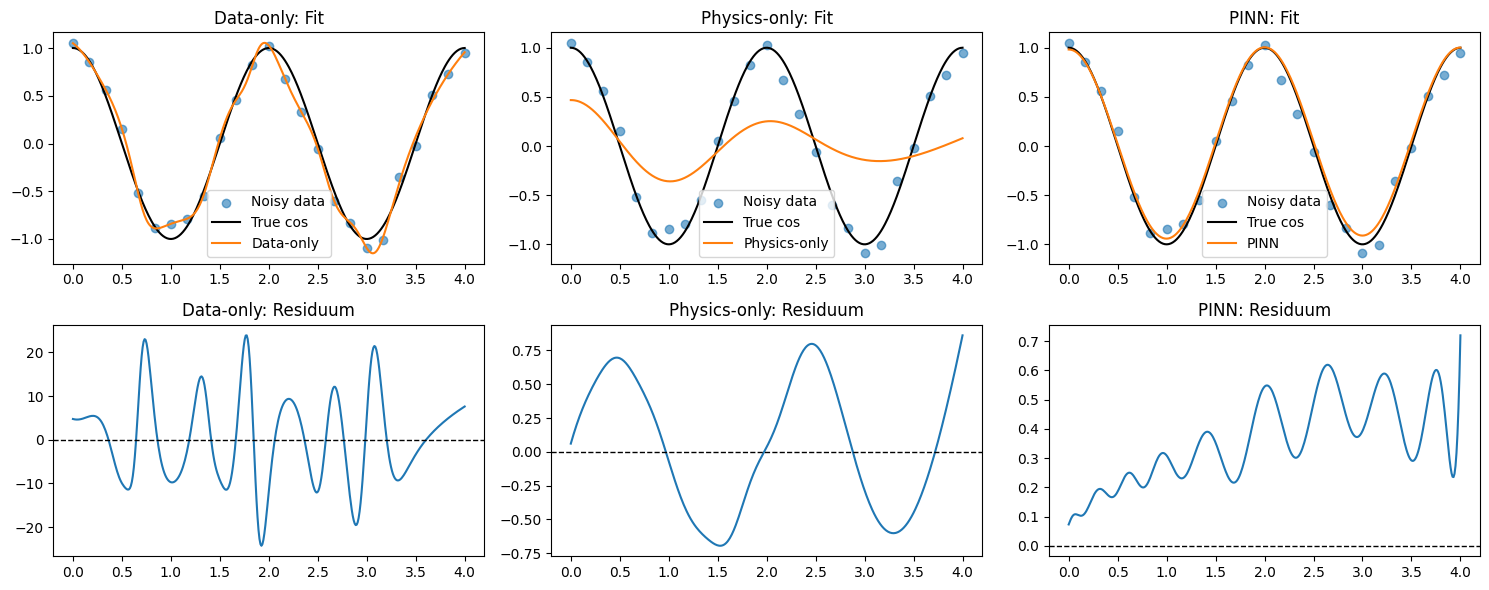

In [58]:
import torch, torch.nn as nn, numpy as np, matplotlib.pyplot as plt

# Setup
np.random.seed(42); torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
f, omega = 0.5, 2*np.pi*0.5

# Daten
N = 25
t_np = np.linspace(0,4,N)
y_true_np = np.cos(omega*t_np)
y_noisy_np = y_true_np + np.random.normal(0,0.1,N)

t_data = torch.tensor(t_np, dtype=torch.float32).reshape(-1,1).to(device)
y_noisy = torch.tensor(y_noisy_np, dtype=torch.float32).reshape(-1,1).to(device)

# Modell
class Net(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.l1 = nn.Linear(1,hidden); self.l2 = nn.Linear(hidden,hidden)
        self.l3 = nn.Linear(hidden,1); self.act = nn.Tanh()
    def forward(self,x):
        x=self.act(self.l1(x)); x=self.act(self.l2(x)); return self.l3(x)
def grad(y,x): return torch.autograd.grad(y,x,torch.ones_like(y),create_graph=True)[0]

# Loss-Funktion für verschiedene Modi
def loss_fn(model,t_data,y_noisy,t_phys,mode="pinn"):
    mse = nn.MSELoss()
    pred_data = model(t_data)
    data_loss = mse(pred_data,y_noisy)
    # Physik
    t_phys_req = t_phys.clone().detach().requires_grad_(True)
    y_phys = model(t_phys_req)
    d1 = grad(y_phys,t_phys_req); d2 = grad(d1,t_phys_req)
    resid = d2 + (omega**2)*y_phys
    phys_loss = mse(resid,torch.zeros_like(resid))
    # IC
    t0=torch.zeros(1,1,device=device,requires_grad=True)
    y0=model(t0); d1_0=grad(y0,t0)
    ic_loss=(y0-1).pow(2).mean()+d1_0.pow(2).mean()
    # Combine
    if mode=="data": return data_loss
    if mode=="phys": return phys_loss+ic_loss
    if mode=="pinn": return data_loss+phys_loss+ic_loss

# Training Helper
def train_model(mode,epochs=10000,lr=1e-3):
    model=Net().to(device); opt=torch.optim.Adam(model.parameters(),lr=lr)
    t_phys=torch.linspace(0,4,200).reshape(-1,1).to(device)
    for ep in range(epochs):
        opt.zero_grad(); loss=loss_fn(model,t_data,y_noisy,t_phys,mode); loss.backward(); opt.step()
    return model

# Trainiere alle drei
model_data=train_model("data")
model_phys=train_model("phys")
model_pinn=train_model("pinn")

# Dense Grid
t_dense=np.linspace(0,4,400).reshape(-1,1).astype(np.float32)
y_true_dense=np.cos(omega*t_dense[:,0])
t_dense_t=torch.from_numpy(t_dense).to(device)

def predict(model): 
    with torch.no_grad(): return model(t_dense_t).cpu().numpy()[:,0]

y_data=predict(model_data); y_phys=predict(model_phys); y_pinn=predict(model_pinn)

# Residuum berechnen
def residuum(model):
    t=torch.from_numpy(t_dense).to(device).requires_grad_(True)
    y=model(t); d1=grad(y,t); d2=grad(d1,t)
    return (d2+(omega**2)*y).detach().cpu().numpy()[:,0]

r_data=residuum(model_data); r_phys=residuum(model_phys); r_pinn=residuum(model_pinn)

# --- Plot ---
fig,axs=plt.subplots(2,3,figsize=(15,6))
names=["Data-only","Physics-only","PINN"]

for i,(y_pred,r_pred,name) in enumerate(zip([y_data,y_phys,y_pinn],
                                            [r_data,r_phys,r_pinn],
                                            names)):
    # Fit-Plot
    axs[0,i].scatter(t_np,y_noisy_np,label="Noisy data",alpha=0.6)
    axs[0,i].plot(t_dense[:,0],y_true_dense,label="True cos",c="k")
    axs[0,i].plot(t_dense[:,0],y_pred,label=name,c="C1")
    axs[0,i].set_title(f"{name}: Fit")
    axs[0,i].legend()
    # Residuum
    axs[1,i].plot(t_dense[:,0],r_pred)
    axs[1,i].axhline(0,ls="--",c="k",lw=1)
    axs[1,i].set_title(f"{name}: Residuum")

plt.tight_layout(); plt.show()


# Early Stopping & Best-Checkpoint

omega = 3.141592653589793
ep   500 | train 8.548267 (d 0.5069, p 0.2132, ic 0.6975) | val 8.571096 (d 0.5185, p 0.2165, ic 0.6970)
ep  1000 | train 6.895559 (d 0.4716, p 0.3610, ic 0.4619) | val 6.818101 (d 0.3992, p 0.3597, ic 0.4620)
ep  1500 | train 6.279139 (d 0.4567, p 0.4069, ic 0.3788) | val 6.170479 (d 0.3605, p 0.4041, ic 0.3789)
ep  2000 | train 5.910602 (d 0.4367, p 0.4404, ic 0.3272) | val 5.799191 (d 0.3223, p 0.4390, ic 0.3282)
ep  2500 | train 5.232723 (d 0.3944, p 0.4208, ic 0.2734) | val 5.104433 (d 0.2669, p 0.4187, ic 0.2744)
ep  3000 | train 4.121612 (d 0.3061, p 0.3964, ic 0.1834) | val 3.995285 (d 0.1917, p 0.3959, ic 0.1824)
ep  3500 | train 3.797346 (d 0.2591, p 0.4355, ic 0.1361) | val 3.692971 (d 0.1531, p 0.4349, ic 0.1365)
ep  4000 | train 3.702173 (d 0.2466, p 0.4411, ic 0.1250) | val 3.616012 (d 0.1430, p 0.4444, ic 0.1251)
ep  4500 | train 3.644894 (d 0.2390, p 0.4434, ic 0.1189) | val 3.556939 (d 0.1362, p 0.4442, ic 0.1200)
ep  5000 | train 3.569386 (d 

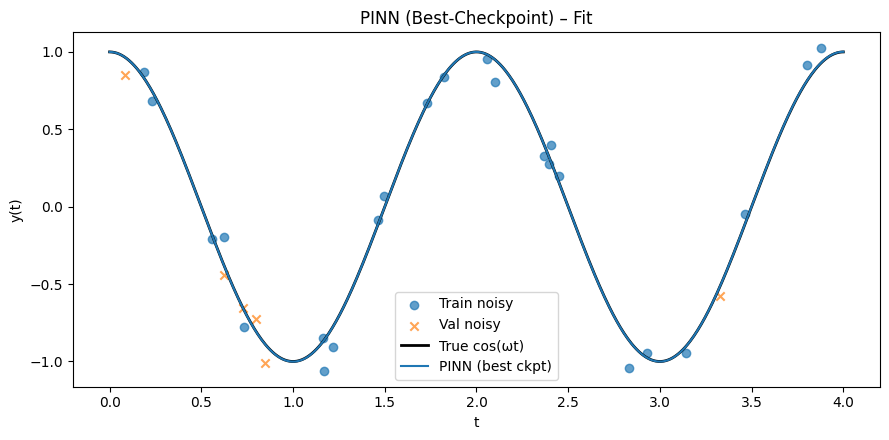

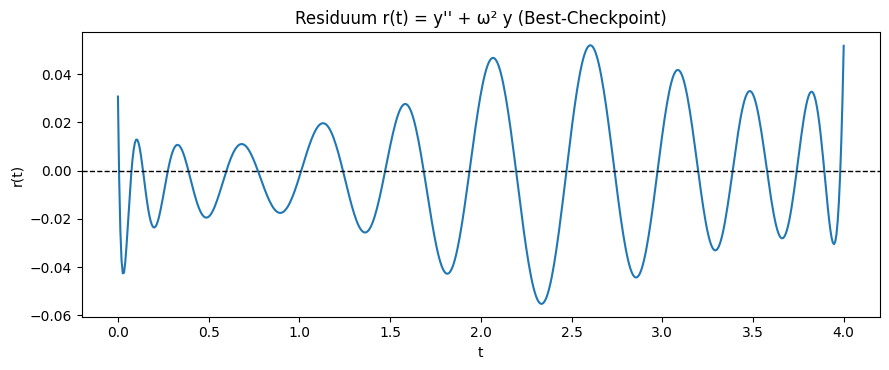

In [61]:
# PINN mit Early Stopping & Best-Checkpoint
# ODE: y'' + ω^2 y = 0,  IC: y(0)=1, y'(0)=0

import torch, torch.nn as nn, numpy as np, matplotlib.pyplot as plt
from copy import deepcopy

# -------------------- Setup --------------------
np.random.seed(42); torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Physik
f = 0.5
omega = 2*np.pi*f  # ≈ pi
print("omega =", omega)

# -------------------- Daten erzeugen (Train/Val) --------------------
N = 30
t_all = np.sort(np.random.uniform(0.0, 4.0, N)).astype(np.float32)
y_true = np.cos(omega * t_all).astype(np.float32)
sigma = 0.10
y_noisy = (y_true + np.random.normal(0.0, sigma, N)).astype(np.float32)

# 80/20 Split
n_tr = int(0.8*N)
idx = np.arange(N); np.random.shuffle(idx)
idx_tr, idx_val = idx[:n_tr], idx[n_tr:]

t_tr_np, y_tr_np = t_all[idx_tr], y_noisy[idx_tr]
t_val_np, y_val_np = t_all[idx_val], y_noisy[idx_val]

t_tr = torch.tensor(t_tr_np).reshape(-1,1).to(device)
y_tr = torch.tensor(y_tr_np).reshape(-1,1).to(device)
t_val = torch.tensor(t_val_np).reshape(-1,1).to(device)
y_val = torch.tensor(y_val_np).reshape(-1,1).to(device)

# Physik-Kollokationspunkte (separat Train/Val)
t_phys_tr = torch.linspace(0,4,240).reshape(-1,1).to(device)
t_phys_val = torch.linspace(0,4,120).reshape(-1,1).to(device)

# -------------------- Modell --------------------
class Net(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        self.act = nn.Tanh()
        self.reset_parameters()
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight); nn.init.zeros_(self.fc3.bias)
    def forward(self, t):
        x = self.act(self.fc1(t))
        x = self.act(self.fc2(x))
        return self.fc3(x)

def ddt(y, t):
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]

mse = nn.MSELoss()

def pinn_loss(model, t_data, y_data, t_phys, omega, lambdas, jitter_std=0.0):
    lam_data, lam_phys, lam_ic = lambdas

    # Data loss
    y_hat = model(t_data)
    loss_data = mse(y_hat, y_data)

    # Physics loss (optional Jitter der Collocation)
    t_phys_use = t_phys
    if jitter_std > 0:
        t_phys_use = (t_phys + jitter_std*torch.randn_like(t_phys)).clamp(0,4)
    t_phys_use = t_phys_use.clone().detach().requires_grad_(True)
    y_phys = model(t_phys_use)
    d1 = ddt(y_phys, t_phys_use)
    d2 = ddt(d1, t_phys_use)
    resid = d2 + (omega**2)*y_phys
    loss_phys = mse(resid, torch.zeros_like(resid))

    # IC: y(0)=1, y'(0)=0
    t0 = torch.zeros(1,1, device=device, requires_grad=True)
    y0 = model(t0)
    dy0 = ddt(y0, t0)
    loss_ic = mse(y0, torch.tensor([[1.0]], device=device)) \
            + mse(dy0, torch.tensor([[0.0]], device=device))

    total = lam_data*loss_data + lam_phys*loss_phys + lam_ic*loss_ic
    return total, loss_data.detach(), loss_phys.detach(), loss_ic.detach()

# -------------------- Early Stopping --------------------
class EarlyStopper:
    def __init__(self, patience=800, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best = np.inf
        self.wait = 0
    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.wait = 0
            return True   # improved
        else:
            self.wait += 1
            return False  # no improvement
    def should_stop(self):
        return self.wait >= self.patience

# -------------------- Training --------------------
model = Net(hidden=32).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# Ältere Torch-Versionen: kein 'verbose' Argument
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=200)

lambda_data, lambda_phys, lambda_ic = 1.0, 5.0, 10.0
early = EarlyStopper(patience=800, min_delta=1e-5)
best_state = None
best_epoch = -1

max_epochs = 20000
for ep in range(1, max_epochs+1):
    # --- Train ---
    model.train()
    opt.zero_grad()
    loss_tr, d_tr, p_tr, ic_tr = pinn_loss(
        model, t_tr, y_tr, t_phys_tr, omega,
        lambdas=(lambda_data, lambda_phys, lambda_ic),
        jitter_std=0.01
    )
    loss_tr.backward()
    opt.step()

    # --- Validation (WICHTIG: Gradients erlaubt, kein no_grad) ---
    model.eval()
    with torch.enable_grad():
        loss_val, d_val, p_val, ic_val = pinn_loss(
            model, t_val, y_val, t_phys_val, omega,
            lambdas=(lambda_data, lambda_phys, lambda_ic),
            jitter_std=0.0
        )

    # LR-Scheduler auf Val-Loss
    old_lr = opt.param_groups[0]['lr']
    scheduler.step(loss_val.item())
    new_lr = opt.param_groups[0]['lr']
    if new_lr < old_lr and ep % 50 == 0:
        print(f"LR: {old_lr:.2e} -> {new_lr:.2e}")

    # Early stopping & Best-Checkpoint
    improved = early.step(loss_val.item())
    if improved:
        best_state = deepcopy(model.state_dict())
        best_epoch = ep
    if early.should_stop():
        print(f"Early stop at epoch {ep} (best @ {best_epoch}, val={early.best:.6f})")
        break

    if ep % 500 == 0:
        print(f"ep {ep:5d} | train {loss_tr.item():.6f} (d {d_tr.item():.4f}, p {p_tr.item():.4f}, ic {ic_tr.item():.4f}) "
              f"| val {loss_val.item():.6f} (d {d_val.item():.4f}, p {p_val.item():.4f}, ic {ic_val.item():.4f})")

# Bestes Modell laden
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best checkpoint @ epoch {best_epoch} (val={early.best:.6f})")

# -------------------- Evaluation & Plots --------------------
t_dense = np.linspace(0,4,600).astype(np.float32).reshape(-1,1)
y_true_dense = np.cos(omega*t_dense[:,0])

with torch.no_grad():
    y_pred_dense = model(torch.tensor(t_dense).to(device)).cpu().numpy()[:,0]

# Residuum (Best-Checkpoint) – OHNE no_grad (wir brauchen Ableitungen!)
t_res = torch.tensor(t_dense).to(device).requires_grad_(True)
y_res = model(t_res); d1 = ddt(y_res, t_res); d2 = ddt(d1, t_res)
resid = (d2 + (omega**2)*y_res).detach().cpu().numpy()[:,0]

plt.figure(figsize=(9,4.5))
plt.scatter(t_tr_np, y_tr_np, label="Train noisy", alpha=0.7)
plt.scatter(t_val_np, y_val_np, label="Val noisy", alpha=0.7, marker='x')
plt.plot(t_dense[:,0], y_true_dense, label="True cos(ωt)", c="k", lw=2)
plt.plot(t_dense[:,0], y_pred_dense, label="PINN (best ckpt)")
plt.title("PINN (Best-Checkpoint) – Fit")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,3.8))
plt.plot(t_dense[:,0], resid); plt.axhline(0, ls="--", c="k", lw=1)
plt.title("Residuum r(t) = y'' + ω² y (Best-Checkpoint)")
plt.xlabel("t"); plt.ylabel("r(t)"); plt.tight_layout(); plt.show()
